In [23]:
import torchvision
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F # 内置的激活函数
import copy # 保存模型权重

from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torch.optim import lr_scheduler # 衰减学习率

torch.cuda.empty_cache()

#### 数据预处理

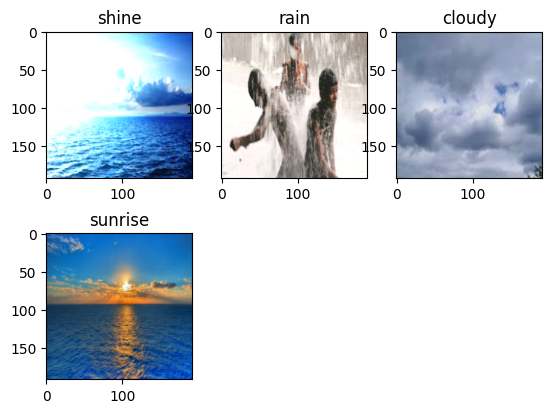

In [24]:
# 训练数据  图像增强
train_transform = transforms.Compose([
    transforms.Resize((224,224)), # 统一大小
    transforms.RandomCrop((192,192)), # 随机裁剪
    transforms.RandomHorizontalFlip(), # 随机水平翻转
    transforms.RandomRotation(0.2), # 随机翻转
                           # 明暗度           对比度
    transforms.ColorJitter(brightness = 0.5, contrast = 0, 
                           saturation = 0, hue = 0),
                           # 饱和度        颜色   
    transforms.ToTensor(), # 规范格式
])

test_transform = transforms.Compose([
    transforms.Resize((192,192)), # 统一大小
    transforms.ToTensor(), # 规范格式
])

train_path = './第8章/4weather/train/'
test_path =   './第8章/4weather/test/'
# 获取数据集
train_ds =  torchvision.datasets.ImageFolder(train_path,transform=train_transform)
test_ds =  torchvision.datasets.ImageFolder(test_path,transform=test_transform)

# 批次管理
batch_size = 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
test_dl = DataLoader(test_ds,batch_size=batch_size)

# 获取一个批次的数据
imgs, labels = next(iter(train_dl))

# 交换字典中键值对的位置 {v: k for k, v in d.items()}
idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}

# 展示图片
for i,(img, label) in enumerate(zip(imgs[:6],labels[:6]),start=0):
    # 改变图片格式为(height, width, channel)
    img = img.permute(1,2,0)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(idx_to_class.get(label.item()))

#### 创建预训练模型

In [13]:
model = torchvision.models.vgg16(pretrained=True).to('cuda')
# model = torchvision.models.resnet101(pretrained=True).to('cuda')

# 冻结卷积部分参数
for param in model.features.parameters():
    param.requires_grad = False

# 修改分类器
model.classifier[-1].out_features = 4 # VGG
# model.fc = nn.Linear(model.fc.in_features,4) # resnet

loss_fn = nn.CrossEntropyLoss()
# 仅优化分类器部分参数
opt = torch.optim.Adam(model.classifier.parameters(), lr=0.001) # VGG
# opt = torch.optim.Adam(model.fc.parameters(), lr=0.001) # resnet

# 定义学习速率衰减           优化器，几步衰减，  衰减率
lr = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

#### 训练函数

In [9]:
# 训练函数
def train(dl, model, loss_fn, optimizer):
    model.train() # 训练模式
    size = len(dl.dataset) # 总的个数    
    num_batches = len(dl) # 总批次数 = 总的个数//每批数
        
    train_loss, correct = 0, 0
        
    for x, y in dl:
        x, y = x.to('cuda'), y.to('cuda')
        pred = model(x)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # pred 第一维是每批数 
            correct += (pred.argmax(1) == y).float().sum().item()
            train_loss += loss.item()
    # lr.step() # 使用学习速率衰减 
    correct /= size
    train_loss /= num_batches
    
    return correct, train_loss

# 测试函数
def test(test_dl, model, loss_fn):
    model.eval() # 预测模式 
    size = len(test_dl.dataset)    
    num_batches = len(test_dl)
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to('cuda'), y.to('cuda')
            pred = model(x)         
            loss = loss_fn(pred, y)
            
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).float().sum().item()
        correct /= size
        test_loss /= num_batches
        return correct, test_loss
    
def fit(epochs,train_dl,test_dl,model, loss_fn, opt):
    # 列表记录每轮的数据
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
        epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
        
        # 追加到列表中
        train_acc.append(epoch_train_acc)
        train_loss.append(epoch_train_loss)
        test_acc.append(epoch_test_acc)
        test_loss.append(epoch_test_loss)
                 
        # 打印模板
        template = ("epoch:{:2d}, train_Loss:{:.5f}, train_acc:{:.1f},test_Loss:{:.5f}, test_acc:{:.1f}")
        
        print(template.format(epoch, epoch_train_loss, epoch_train_acc*100, epoch_test_loss, epoch_test_acc*100))
    print('Done')
    
    return train_loss,train_acc,test_loss,test_acc

#### 训练

In [ ]:
epochs = 5
(train_loss,
 train_acc,
 test_loss,
 test_acc) = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, loss_fn=loss_fn, opt=opt)

plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), test_loss, label='test_loss')
plt.legend()

plt.plot(range(epochs), train_acc, label='train_acc')
plt.plot(range(epochs), test_acc, label='test_acc')
plt.legend() 

#### 微调(先调分类器，再一起调卷积基部分)

In [ ]:
# 解冻卷积部分
for param in model.features.parameters():
    param.requires_grad = True
    
opt = torch.optim.Adam(model.parameters, lr=0.0001) # 微调全部参数，lr设置小点

epochs_new = 30
(train_loss_new,
 train_acc_new,
 test_loss_new,
 test_acc_new) = fit(epochs=epochs_new, train_dl=train_dl, test_dl=test_dl, model=model, loss_fn=loss_fn, opt=opt)

plt.plot(range(epochs_new), train_loss_new, label='train_loss_new')
plt.plot(range(epochs_new), test_loss_new, label='test_loss_new')
plt.legend()

plt.plot(range(epochs_new), train_acc_new, label='train_acc_new')
plt.plot(range(epochs_new), test_acc_new, label='test_acc_new')
plt.legend()  

#### 保存模型权重参数

In [ ]:
model_path = './model.pth' # 保存位置
torch.save(model.state_dict(), model_path) # 保存权重参数

new_model = model().to('cuda') 
new_model.load_state_dict(torch.load(model_path)) # 加载模型权重参数